# **libary**

In [19]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# **DATA ACQUISITION & INGESTION**

In [20]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df = pd.read_csv(URL)

In [21]:
# Konfigurasi visualisasi global
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# **EXPLORATORY DATA ANALYSIS (SQL ENGINE)**

In [22]:
# Membangun lingkungan SQL in-memory untuk pemrosesan data relasional
conn = sqlite3.connect(':memory:')
df.to_sql('launches', conn, index=False)

90

In [23]:
# Analisis kompleks: Rasio sukses berdasarkan kombinasi Orbit dan Site
query_complex = """
SELECT LaunchSite, Orbit, COUNT(*) as Launch_Count, AVG(Class) as Success_Rate
FROM launches
GROUP BY LaunchSite, Orbit
ORDER BY Success_Rate DESC
"""
df_complex_sql = pd.read_sql(query_complex, conn)
print("--- Advanced SQL Analytics: Success Rate by Orbit & Site ---")
print(df_complex_sql.head(10))

--- Advanced SQL Analytics: Success Rate by Orbit & Site ---
     LaunchSite  Orbit  Launch_Count  Success_Rate
0  CCAFS SLC 40  ES-L1             1      1.000000
1  CCAFS SLC 40    GEO             1      1.000000
2  CCAFS SLC 40    HEO             1      1.000000
3  CCAFS SLC 40    SSO             1      1.000000
4    KSC LC 39A    ISS             5      1.000000
5    KSC LC 39A    LEO             2      1.000000
6   VAFB SLC 4E    SSO             4      1.000000
7  CCAFS SLC 40   VLEO             9      0.888889
8    KSC LC 39A   VLEO             5      0.800000
9  CCAFS SLC 40    MEO             3      0.666667


# **ADVANCED VISUALIZATION (EDA)**

In [24]:
# Visualisasi Interaktif Geospasial dengan Folium
# Menampilkan konsentrasi lokasi peluncuran di pesisir Timur (Florida) dan Barat (California)
map_spacex = folium.Map(location=[28.56, -80.57], zoom_start=4)

In [25]:
# Menambahkan Launch Sites utama
sites = {
    'CCAFS SLC 40': [28.5623, -80.5774],
    'KSC LC 39A': [28.5732, -80.6469],
    'VAFB SLC 4E': [34.6328, -120.6107]
}

for site, coord in sites.items():
    folium.Marker(coord, popup=site, icon=folium.Icon(color='red', icon='rocket', prefix='fa')).add_to(map_spacex)
map_spacex.save("spacex_launch_locations.html")

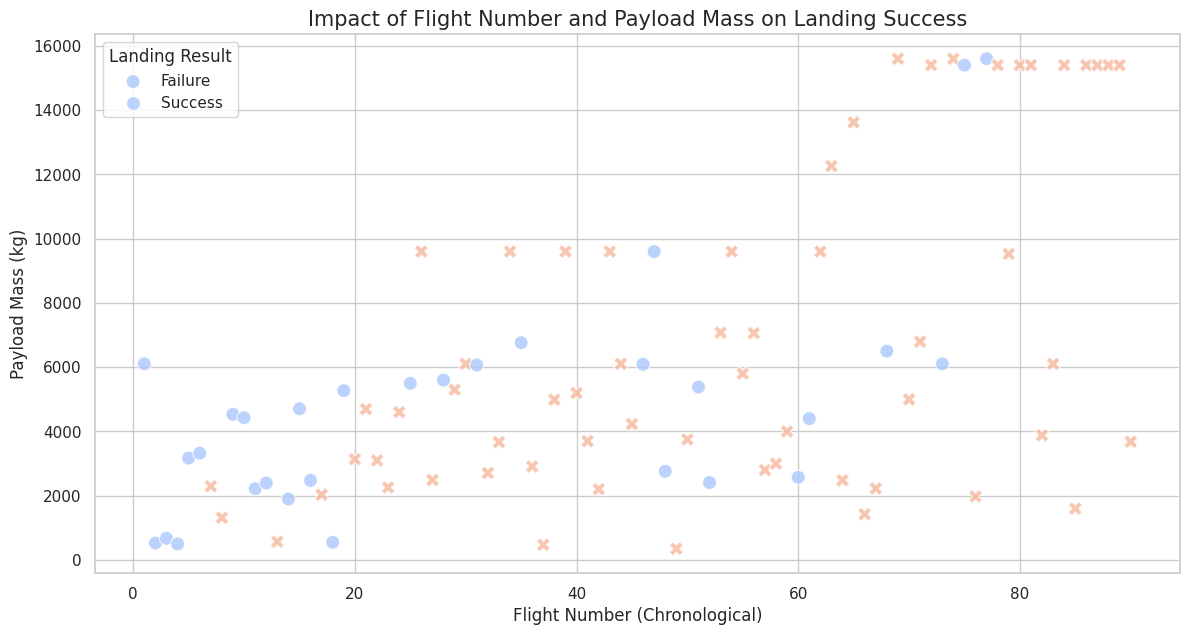

In [26]:
# Visualisasi Korelasi Muatan dan Keberhasilan
plt.figure(figsize=(14, 7))
sns.scatterplot(x="FlightNumber", y="PayloadMass", hue="Class", style="Class",
                s=100, alpha=0.8, palette='coolwarm', data=df)
plt.title("Impact of Flight Number and Payload Mass on Landing Success", fontsize=15)
plt.xlabel("Flight Number (Chronological)", fontsize=12)
plt.ylabel("Payload Mass (kg)", fontsize=12)
plt.legend(title='Landing Result', labels=['Failure', 'Success'])
plt.show()

# **PREDICTIVE MODELING (MACHINE LEARNING)**

In [27]:
# Feature Selection: Memilih variabel prediktor teknis
features = ['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'Reused', 'Legs', 'Block', 'ReusedCount']
X = df[features]
y = df['Class']

In [28]:
# Data Splitting dengan Stratifikasi (Menjaga rasio target sukses/gagal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [29]:
# Feature Scaling (Penting untuk algoritma berbasis jarak dan stabilitas model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Hyperparameter Tuning menggunakan GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
tree_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

# **MODEL EVALUATION & INTERPRETATION**

In [31]:
best_model = tree_cv.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print(f"\nBest Hyperparameters: {tree_cv.best_params_}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test Set Accuracy: 0.7222

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.77      0.83      0.80        12

    accuracy                           0.72        18
   macro avg       0.68      0.67      0.67        18
weighted avg       0.71      0.72      0.72        18



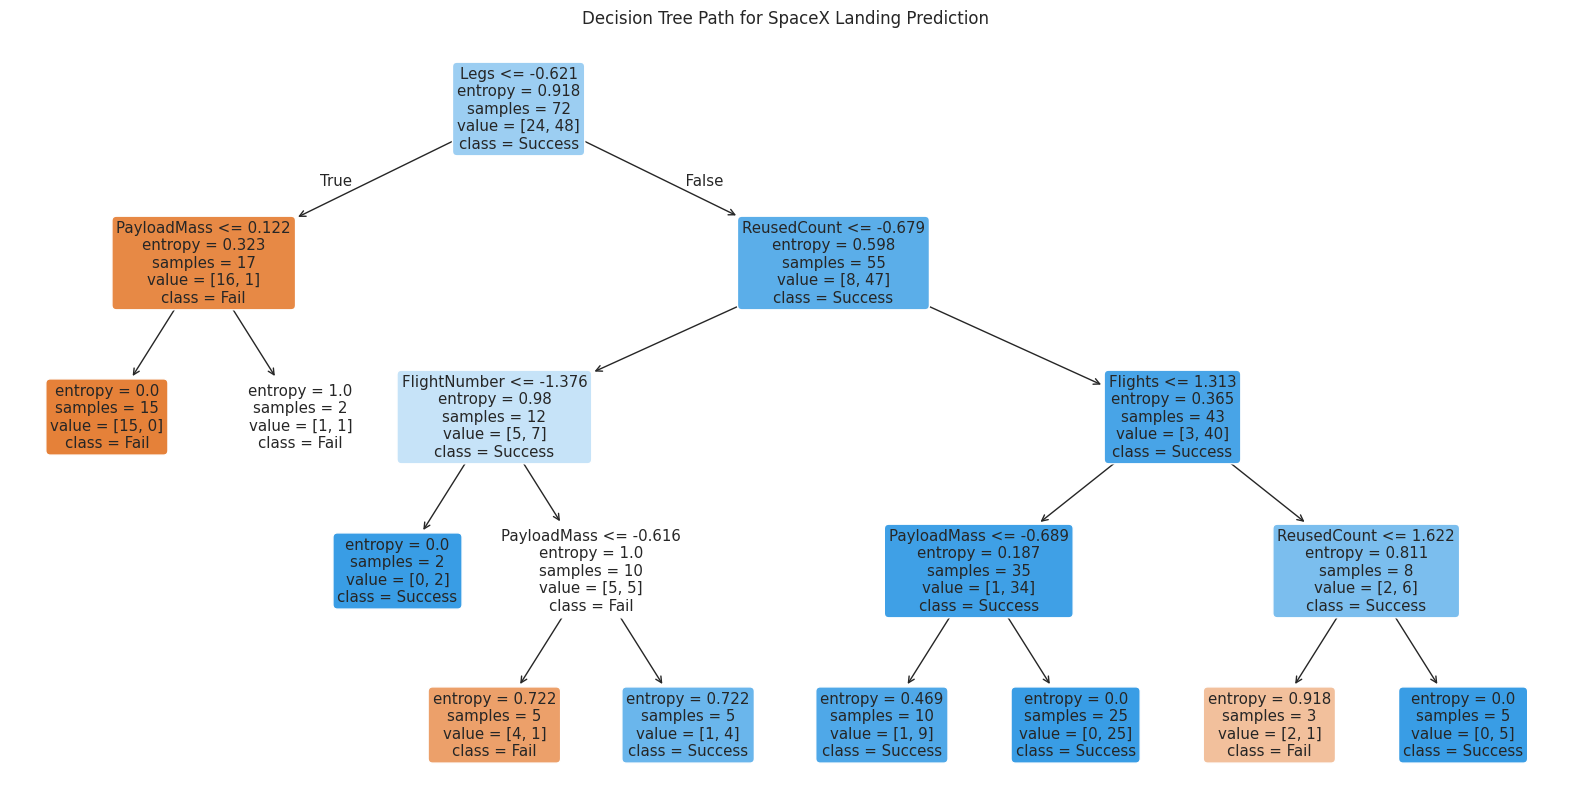

In [32]:
# Visualisasi Decision Tree (Interpretability)
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=features, class_names=['Fail', 'Success'], filled=True, rounded=True)
plt.title("Decision Tree Path for SpaceX Landing Prediction")
plt.show()